In [89]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import STL10, MNIST
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from typing import List, TypeVar
from tqdm import tqdm  # for progress bar
import numpy as np

Tensor = TypeVar('torch.tensor')


from ssl_methods.beta_vae.components import ResNet18Encoder, ResNet18Decoder
from ssl_methods.beta_vae.b_vae import BetaVae

## POBRANIE DATASETOW


In [102]:
def get_dataset(dataset_name='stl10'):
    if dataset_name == 'stl10':
        transform = transforms.Compose([
            transforms.Resize((96, 96)),  # Resize to desired size
            transforms.ToTensor()
        ])
        train_dataset = STL10(root='./data', split='unlabeled', download=True, transform=transform)
        test_dataset = STL10(root='./data', split='test', download=True, transform=transform)
    elif dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.Resize((96, 96)), 
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
        train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Dataset not supported: choose 'stl10' or 'mnist'")
    
    return train_dataset, test_dataset

## MNIST was used to check quality of representation with easier dataset
dataset_name = 'stl10'  # Change to 'mnist' to use the MNIST dataset
train_dataset, _ = get_dataset(dataset_name)

def get_subset_indices(dataset, percentage=0.01):
    num_samples = len(dataset)
    subset_size = int(num_samples * percentage)
    indices = np.random.choice(num_samples, subset_size, replace=False)
    return indices

subset_indices = get_subset_indices(train_dataset, percentage=0.25)
subset_dataset = Subset(train_dataset, subset_indices)

# Split the subset dataset into training and validation sets
train_size = int(0.8 * len(subset_dataset))
val_size = len(subset_dataset) - train_size
train_dataset, val_dataset = random_split(subset_dataset, [train_size, val_size])


Files already downloaded and verified
Files already downloaded and verified


## TEST DLA WYBRANYCH HIPERPARAMETROW


Epoch 1/1: 100%|██████████| 157/157 [01:34<00:00,  1.66it/s, Train Loss=0.00533]


Epoch [1/1], Train Loss: 0.0013383, Val Loss: 0.0004069


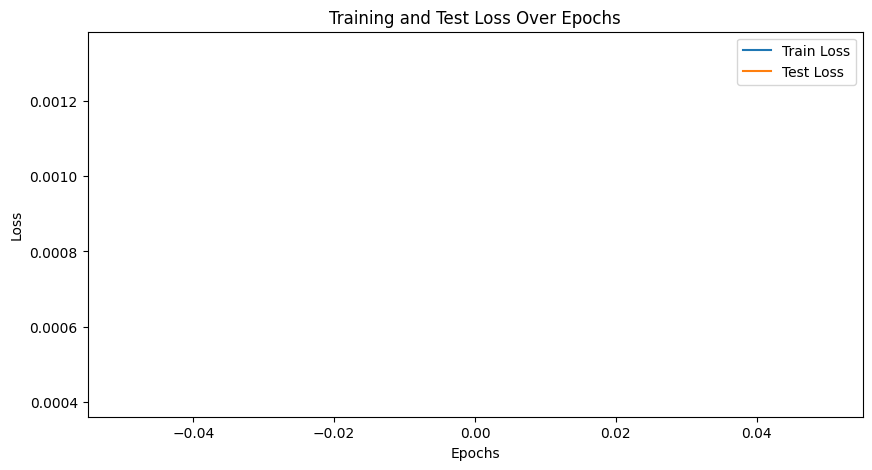

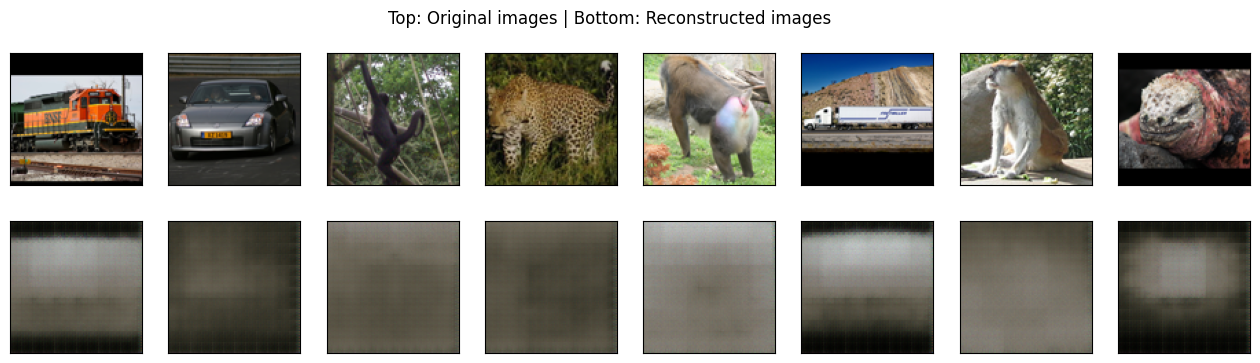

In [106]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training the VAE
num_epochs = 1

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

# Initialize the BetaVAE model
model = BetaVae(beta=2,in_channels=3, latent_dim=128).to(device)  # Adjust latent_dim as needed

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

early_stopping_patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (data, _) in enumerate(pbar):
        data = data.to(device, dtype=torch.float32)  # Ensure data is float32 and on the correct device
        optimizer.zero_grad()
        
        recons, input, mu, log_var = model(data)
        loss_dict = model.loss_function(recons, input, mu, log_var, M_N=0.005)  # M_N is minibatch weight
        loss = loss_dict['loss']
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        pbar.set_postfix({'Train Loss': train_loss / ((batch_idx + 1) * data.size(0))})
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device, dtype=torch.float32)
            recons, input, mu, log_var = model(data)
            loss_dict = model.loss_function(recons, input, mu, log_var, M_N=0.005)
            val_loss += loss_dict['loss'].item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.7f}, Val Loss: {val_loss:.7f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss Over Epochs')
plt.show()

# Display original and reconstructed images
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device, dtype=torch.float32)
    recons, input, mu, log_var = model(images)

    # Convert images to CPU for matplotlib
    images = images.cpu()
    recons = recons.cpu()

    # Rescale images from [0, 1] to [0, 255]
    images = images * 255
    recons = recons * 255

    # Convert images to uint8 for proper display
    images = images.byte()
    recons = recons.byte()

    # Plot original images
    fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(16, 4))
    for imgs, row in zip([images, recons], axes):
        for img, ax in zip(imgs, row):
            ax.imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    fig.suptitle('Top: Original images | Bottom: Reconstructed images')
    plt.show()

In [79]:
torch.save(model.state_dict(), 'beta_vae_model2.pth')

## WIZUALIZACJA REPREZENTACJI


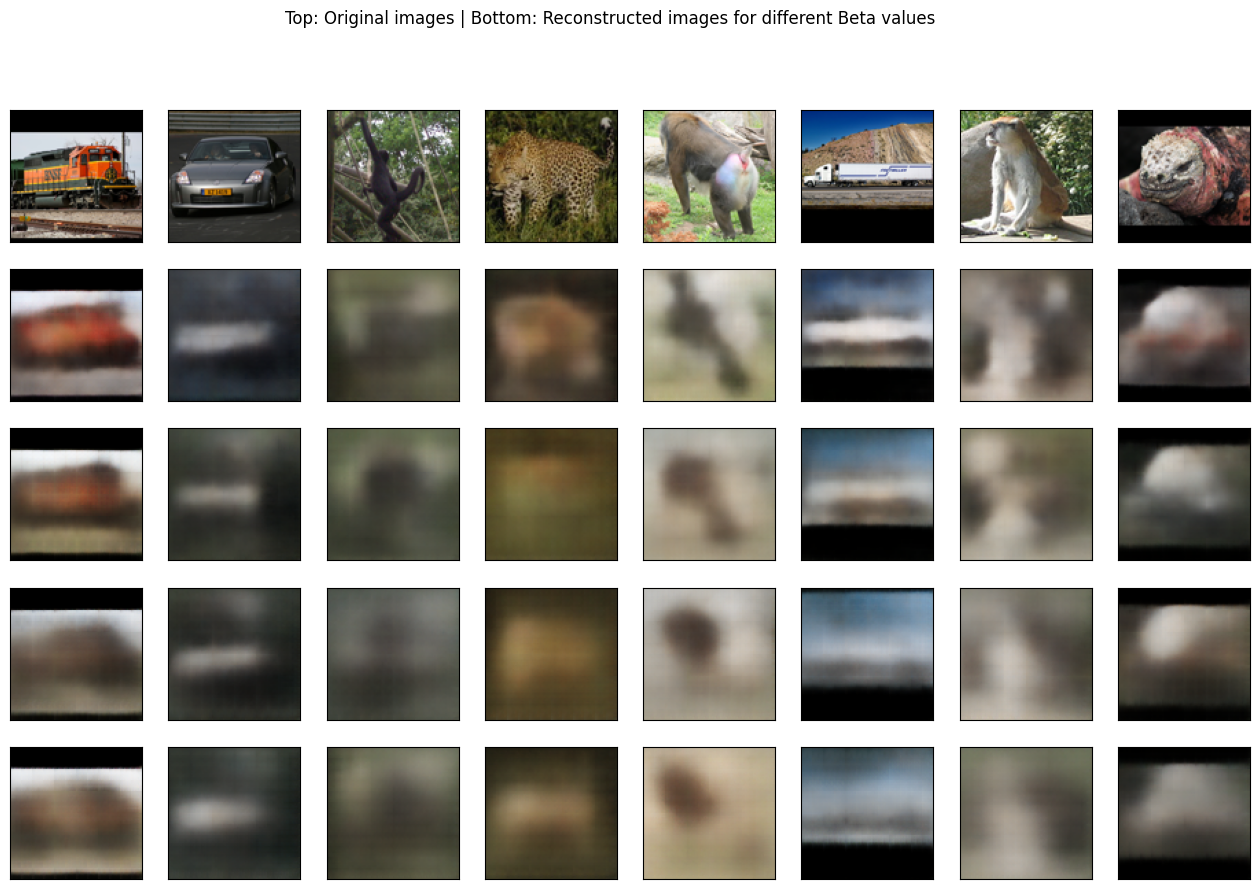

In [121]:
import torch
import matplotlib.pyplot as plt

# Function to load a BetaVae model
def load_model(filepath, beta, in_channels, latent_dim):
    model = BetaVae(beta=beta, in_channels=in_channels, latent_dim=latent_dim)
    model.load_state_dict(torch.load(filepath))
    return model

# Initialize the device
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
else:
    device = torch.device("mps")

# Model parameters
betas = [1, 2, 3, 4]
batch_size = 32
latent_dim = 64

# Load a batch of validation images
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device, dtype=torch.float32)

# Plot original and reconstructed images for each model
fig, axes = plt.subplots(nrows=5, ncols=8, sharex=True, sharey=True, figsize=(16, 10))

# Plot original images in the first row
original_images = images.cpu() * 255
original_images = original_images.byte()

for img, ax in zip(original_images, axes[0]):
    ax.imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
axes[0, 0].set_ylabel('Original')

# Load and process each model
for i, beta in enumerate(betas):
    model_filename = f"beta_vae_beta_{beta}.pth"
    model = load_model(model_filename, beta=beta, in_channels=3, latent_dim=latent_dim).to(device)
    model.eval()

    with torch.no_grad():
        recons, input, mu, log_var = model(images)

    recons = recons.cpu() * 255
    recons = recons.byte()

    for img, ax in zip(recons, axes[i+1]):
        ax.imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    axes[i+1, 0].set_ylabel(f'Beta {beta}')

fig.suptitle('Top: Original images | Bottom: Reconstructed images for different Beta values')
plt.show()

## GRID SEARCH PO PARAMETRACH



In [117]:
betas = [4,3,2,1]
batch_sizes = [32]
latent_dims = [64]

for beta in betas:
    for batch_size in batch_sizes:
        for latent_dim in latent_dims:
            # Data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Training the VAE
            num_epochs = 50

            if not torch.backends.mps.is_available():
                if not torch.backends.mps.is_built():
                    print("MPS not available because the current PyTorch install was not "
                          "built with MPS enabled.")
                else:
                    print("MPS not available because the current MacOS version is not 12.3+ "
                          "and/or you do not have an MPS-enabled device on this machine.")
                device = torch.device("cpu")
            else:
                device = torch.device("mps")

            # Initialize the BetaVAE model
            model = BetaVae(beta=beta, in_channels=3, latent_dim=latent_dim).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            train_losses = []
            val_losses = []

            early_stopping_patience = 5
            best_val_loss = float('inf')
            early_stopping_counter = 0

            for epoch in range(num_epochs):
                model.train()
                train_loss = 0
                pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
                for batch_idx, (data, _) in enumerate(pbar):
                    data = data.to(device, dtype=torch.float32)  # Ensure data is float32 and on the correct device
                    optimizer.zero_grad()
                    
                    recons, input, mu, log_var = model(data)
                    loss_dict = model.loss_function(recons, input, mu, log_var)  # M_N is minibatch weight
                    loss = loss_dict['loss']
                    
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    
                    pbar.set_postfix({'Train Loss': train_loss / ((batch_idx + 1) * data.size(0))})
                
                train_loss /= len(train_loader.dataset)
                train_losses.append(train_loss)
                
                # Evaluate on validation set
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_idx, (data, _) in enumerate(val_loader):
                        data = data.to(device, dtype=torch.float32)
                        recons, input, mu, log_var = model(data)
                        loss_dict = model.loss_function(recons, input, mu, log_var, M_N=0.005)
                        val_loss += loss_dict['loss'].item()
                
                val_loss /= len(val_loader.dataset)
                val_losses.append(val_loss)
                
                print(f'Epoch [{epoch+1}/{num_epochs}], Beta: {beta}, Batch Size: {batch_size}, Latent Dim: {latent_dim}, Train Loss: {train_loss:.7f}, Val Loss: {val_loss:.7f}')

                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                    # Save the model when validation loss improves
                    model_filename = f"beta_vae_beta_{beta}.pth"
                    torch.save(model.state_dict(), model_filename)
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_patience:
                        print("Early stopping triggered")
                        break

Epoch 1/50: 100%|██████████| 625/625 [01:06<00:00,  9.35it/s, Train Loss=0.00302]


Epoch [1/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0030153, Val Loss: 0.0016440


Epoch 2/50: 100%|██████████| 625/625 [02:12<00:00,  4.72it/s, Train Loss=0.00156]


Epoch [2/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0015609, Val Loss: 0.0014543


Epoch 3/50: 100%|██████████| 625/625 [02:11<00:00,  4.75it/s, Train Loss=0.00143]


Epoch [3/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0014267, Val Loss: 0.0013581


Epoch 4/50: 100%|██████████| 625/625 [02:15<00:00,  4.62it/s, Train Loss=0.00136]


Epoch [4/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0013619, Val Loss: 0.0013343


Epoch 5/50: 100%|██████████| 625/625 [02:13<00:00,  4.69it/s, Train Loss=0.00132]


Epoch [5/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0013209, Val Loss: 0.0012873


Epoch 6/50: 100%|██████████| 625/625 [02:05<00:00,  4.98it/s, Train Loss=0.00127]


Epoch [6/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0012742, Val Loss: 0.0012629


Epoch 7/50: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, Train Loss=0.00125]


Epoch [7/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0012450, Val Loss: 0.0012182


Epoch 8/50: 100%|██████████| 625/625 [02:09<00:00,  4.83it/s, Train Loss=0.00122]


Epoch [8/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0012196, Val Loss: 0.0011933


Epoch 9/50: 100%|██████████| 625/625 [02:15<00:00,  4.61it/s, Train Loss=0.0012] 


Epoch [9/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011959, Val Loss: 0.0011594


Epoch 10/50: 100%|██████████| 625/625 [02:13<00:00,  4.70it/s, Train Loss=0.00118]


Epoch [10/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011763, Val Loss: 0.0011489


Epoch 11/50: 100%|██████████| 625/625 [02:21<00:00,  4.40it/s, Train Loss=0.00116]


Epoch [11/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011606, Val Loss: 0.0011447


Epoch 12/50: 100%|██████████| 625/625 [02:15<00:00,  4.62it/s, Train Loss=0.00115]


Epoch [12/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011472, Val Loss: 0.0011216


Epoch 13/50: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s, Train Loss=0.00113]


Epoch [13/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011317, Val Loss: 0.0011211


Epoch 14/50: 100%|██████████| 625/625 [02:26<00:00,  4.26it/s, Train Loss=0.00112]


Epoch [14/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011209, Val Loss: 0.0011115


Epoch 15/50: 100%|██████████| 625/625 [02:17<00:00,  4.53it/s, Train Loss=0.00111]


Epoch [15/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011080, Val Loss: 0.0010884


Epoch 16/50: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s, Train Loss=0.0011] 


Epoch [16/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010992, Val Loss: 0.0010784


Epoch 17/50: 100%|██████████| 625/625 [02:27<00:00,  4.24it/s, Train Loss=0.0011] 


Epoch [17/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010957, Val Loss: 0.0011076


Epoch 18/50: 100%|██████████| 625/625 [02:21<00:00,  4.41it/s, Train Loss=0.00109]


Epoch [18/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010917, Val Loss: 0.0011097


Epoch 19/50: 100%|██████████| 625/625 [02:24<00:00,  4.31it/s, Train Loss=0.00109]


Epoch [19/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010855, Val Loss: 0.0010895


Epoch 20/50: 100%|██████████| 625/625 [03:03<00:00,  3.41it/s, Train Loss=0.00108]


Epoch [20/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010818, Val Loss: 0.0010824


Epoch 21/50: 100%|██████████| 625/625 [02:56<00:00,  3.53it/s, Train Loss=0.00107]


Epoch [21/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010750, Val Loss: 0.0010650


Epoch 22/50: 100%|██████████| 625/625 [03:31<00:00,  2.96it/s, Train Loss=0.00107]


Epoch [22/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010735, Val Loss: 0.0010959


Epoch 23/50: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s, Train Loss=0.00107]


Epoch [23/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010714, Val Loss: 0.0010733


Epoch 24/50: 100%|██████████| 625/625 [02:34<00:00,  4.05it/s, Train Loss=0.00107]


Epoch [24/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010655, Val Loss: 0.0010831


Epoch 25/50: 100%|██████████| 625/625 [02:24<00:00,  4.33it/s, Train Loss=0.00106]


Epoch [25/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010647, Val Loss: 0.0010700


Epoch 26/50: 100%|██████████| 625/625 [02:17<00:00,  4.55it/s, Train Loss=0.00106]


Epoch [26/50], Beta: 4, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010585, Val Loss: 0.0010758
Early stopping triggered


Epoch 1/50: 100%|██████████| 625/625 [02:30<00:00,  4.17it/s, Train Loss=0.00143]


Epoch [1/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0014270, Val Loss: 0.0012197


Epoch 2/50: 100%|██████████| 625/625 [02:26<00:00,  4.28it/s, Train Loss=0.0012] 


Epoch [2/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0012022, Val Loss: 0.0011580


Epoch 3/50: 100%|██████████| 625/625 [03:33<00:00,  2.93it/s, Train Loss=0.00116]


Epoch [3/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011568, Val Loss: 0.0011243


Epoch 4/50: 100%|██████████| 625/625 [03:49<00:00,  2.72it/s, Train Loss=0.00113]


Epoch [4/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011289, Val Loss: 0.0011189


Epoch 5/50: 100%|██████████| 625/625 [03:28<00:00,  2.99it/s, Train Loss=0.00109]


Epoch [5/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010941, Val Loss: 0.0010739


Epoch 6/50: 100%|██████████| 625/625 [04:24<00:00,  2.37it/s, Train Loss=0.00106]


Epoch [6/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010642, Val Loss: 0.0010620


Epoch 7/50: 100%|██████████| 625/625 [02:56<00:00,  3.54it/s, Train Loss=0.00105]


Epoch [7/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010511, Val Loss: 0.0010645


Epoch 8/50: 100%|██████████| 625/625 [04:02<00:00,  2.58it/s, Train Loss=0.00104]


Epoch [8/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010369, Val Loss: 0.0010250


Epoch 9/50: 100%|██████████| 625/625 [02:25<00:00,  4.30it/s, Train Loss=0.00103]


Epoch [9/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010275, Val Loss: 0.0010287


Epoch 10/50: 100%|██████████| 625/625 [04:23<00:00,  2.37it/s, Train Loss=0.00102]


Epoch [10/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010219, Val Loss: 0.0010625


Epoch 11/50: 100%|██████████| 625/625 [02:56<00:00,  3.55it/s, Train Loss=0.00101]


Epoch [11/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010148, Val Loss: 0.0010121


Epoch 12/50: 100%|██████████| 625/625 [02:33<00:00,  4.06it/s, Train Loss=0.00101] 


Epoch [12/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010135, Val Loss: 0.0010312


Epoch 13/50: 100%|██████████| 625/625 [02:25<00:00,  4.28it/s, Train Loss=0.00101]


Epoch [13/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010090, Val Loss: 0.0010028


Epoch 14/50: 100%|██████████| 625/625 [02:22<00:00,  4.37it/s, Train Loss=0.001]   


Epoch [14/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010022, Val Loss: 0.0010131


Epoch 15/50: 100%|██████████| 625/625 [01:52<00:00,  5.56it/s, Train Loss=0.000999]


Epoch [15/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009988, Val Loss: 0.0009924


Epoch 16/50: 100%|██████████| 625/625 [01:57<00:00,  5.31it/s, Train Loss=0.000995]


Epoch [16/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009948, Val Loss: 0.0009938


Epoch 17/50: 100%|██████████| 625/625 [02:18<00:00,  4.52it/s, Train Loss=0.000992]


Epoch [17/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009921, Val Loss: 0.0009992


Epoch 18/50: 100%|██████████| 625/625 [02:17<00:00,  4.55it/s, Train Loss=0.000987]


Epoch [18/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009871, Val Loss: 0.0009908


Epoch 19/50: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s, Train Loss=0.000986]


Epoch [19/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009861, Val Loss: 0.0009888


Epoch 20/50: 100%|██████████| 625/625 [02:03<00:00,  5.06it/s, Train Loss=0.000982]


Epoch [20/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009822, Val Loss: 0.0009979


Epoch 21/50: 100%|██████████| 625/625 [02:06<00:00,  4.95it/s, Train Loss=0.000979]


Epoch [21/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009789, Val Loss: 0.0009957


Epoch 22/50: 100%|██████████| 625/625 [02:14<00:00,  4.66it/s, Train Loss=0.000976]


Epoch [22/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009764, Val Loss: 0.0010039


Epoch 23/50: 100%|██████████| 625/625 [02:13<00:00,  4.67it/s, Train Loss=0.000974]


Epoch [23/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009743, Val Loss: 0.0010045


Epoch 24/50: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s, Train Loss=0.000973]


Epoch [24/50], Beta: 3, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009729, Val Loss: 0.0009968
Early stopping triggered


Epoch 1/50: 100%|██████████| 625/625 [03:02<00:00,  3.42it/s, Train Loss=0.00139]


Epoch [1/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0013923, Val Loss: 0.0011549


Epoch 2/50: 100%|██████████| 625/625 [02:58<00:00,  3.50it/s, Train Loss=0.00113]


Epoch [2/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0011256, Val Loss: 0.0010981


Epoch 3/50: 100%|██████████| 625/625 [01:53<00:00,  5.51it/s, Train Loss=0.00106]


Epoch [3/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010621, Val Loss: 0.0010107


Epoch 4/50: 100%|██████████| 625/625 [01:48<00:00,  5.74it/s, Train Loss=0.00102]


Epoch [4/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010194, Val Loss: 0.0009972


Epoch 5/50: 100%|██████████| 625/625 [01:53<00:00,  5.52it/s, Train Loss=0.000999]


Epoch [5/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009990, Val Loss: 0.0009717


Epoch 6/50: 100%|██████████| 625/625 [03:25<00:00,  3.04it/s, Train Loss=0.000984]


Epoch [6/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009845, Val Loss: 0.0010050


Epoch 7/50: 100%|██████████| 625/625 [02:55<00:00,  3.56it/s, Train Loss=0.000978]


Epoch [7/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009782, Val Loss: 0.0009681


Epoch 8/50: 100%|██████████| 625/625 [02:03<00:00,  5.06it/s, Train Loss=0.000967]


Epoch [8/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009673, Val Loss: 0.0009580


Epoch 9/50: 100%|██████████| 625/625 [02:07<00:00,  4.91it/s, Train Loss=0.000959]


Epoch [9/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009595, Val Loss: 0.0009698


Epoch 10/50: 100%|██████████| 625/625 [02:02<00:00,  5.10it/s, Train Loss=0.000951]


Epoch [10/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009513, Val Loss: 0.0009455


Epoch 11/50: 100%|██████████| 625/625 [03:37<00:00,  2.87it/s, Train Loss=0.000944]


Epoch [11/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009444, Val Loss: 0.0009442


Epoch 12/50: 100%|██████████| 625/625 [02:38<00:00,  3.95it/s, Train Loss=0.00094] 


Epoch [12/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009398, Val Loss: 0.0009417


Epoch 13/50: 100%|██████████| 625/625 [02:04<00:00,  5.03it/s, Train Loss=0.000936]


Epoch [13/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009360, Val Loss: 0.0009397


Epoch 14/50: 100%|██████████| 625/625 [01:55<00:00,  5.39it/s, Train Loss=0.000929]


Epoch [14/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009286, Val Loss: 0.0009255


Epoch 15/50: 100%|██████████| 625/625 [01:57<00:00,  5.32it/s, Train Loss=0.000925]


Epoch [15/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009246, Val Loss: 0.0009209


Epoch 16/50: 100%|██████████| 625/625 [02:00<00:00,  5.20it/s, Train Loss=0.000922]


Epoch [16/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009221, Val Loss: 0.0009486


Epoch 17/50: 100%|██████████| 625/625 [01:59<00:00,  5.23it/s, Train Loss=0.000918]


Epoch [17/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009182, Val Loss: 0.0009220


Epoch 18/50: 100%|██████████| 625/625 [01:58<00:00,  5.29it/s, Train Loss=0.000913]


Epoch [18/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009130, Val Loss: 0.0009145


Epoch 19/50: 100%|██████████| 625/625 [01:58<00:00,  5.28it/s, Train Loss=0.000909]


Epoch [19/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009093, Val Loss: 0.0009174


Epoch 20/50: 100%|██████████| 625/625 [01:58<00:00,  5.29it/s, Train Loss=0.000906]


Epoch [20/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009058, Val Loss: 0.0009158


Epoch 21/50: 100%|██████████| 625/625 [01:59<00:00,  5.22it/s, Train Loss=0.000905]


Epoch [21/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009052, Val Loss: 0.0009157


Epoch 22/50: 100%|██████████| 625/625 [01:57<00:00,  5.31it/s, Train Loss=0.000902]


Epoch [22/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009016, Val Loss: 0.0009122


Epoch 23/50: 100%|██████████| 625/625 [02:00<00:00,  5.20it/s, Train Loss=0.000899]


Epoch [23/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008987, Val Loss: 0.0009593


Epoch 24/50: 100%|██████████| 625/625 [02:00<00:00,  5.21it/s, Train Loss=0.0009]  


Epoch [24/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008999, Val Loss: 0.0009048


Epoch 25/50: 100%|██████████| 625/625 [02:45<00:00,  3.79it/s, Train Loss=0.000893]


Epoch [25/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008932, Val Loss: 0.0009061


Epoch 26/50: 100%|██████████| 625/625 [03:37<00:00,  2.88it/s, Train Loss=0.000891]


Epoch [26/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008914, Val Loss: 0.0009025


Epoch 27/50: 100%|██████████| 625/625 [02:12<00:00,  4.73it/s, Train Loss=0.000888]


Epoch [27/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008881, Val Loss: 0.0008981


Epoch 28/50: 100%|██████████| 625/625 [03:20<00:00,  3.11it/s, Train Loss=0.000885]


Epoch [28/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008851, Val Loss: 0.0009001


Epoch 29/50: 100%|██████████| 625/625 [02:20<00:00,  4.44it/s, Train Loss=0.000885]


Epoch [29/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008846, Val Loss: 0.0008980


Epoch 30/50: 100%|██████████| 625/625 [02:05<00:00,  4.97it/s, Train Loss=0.000883]


Epoch [30/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008827, Val Loss: 0.0008949


Epoch 31/50: 100%|██████████| 625/625 [02:52<00:00,  3.63it/s, Train Loss=0.00088] 


Epoch [31/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008797, Val Loss: 0.0008973


Epoch 32/50: 100%|██████████| 625/625 [02:17<00:00,  4.55it/s, Train Loss=0.000881]


Epoch [32/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008815, Val Loss: 0.0008917


Epoch 33/50: 100%|██████████| 625/625 [02:05<00:00,  4.97it/s, Train Loss=0.000877]


Epoch [33/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008766, Val Loss: 0.0008894


Epoch 34/50: 100%|██████████| 625/625 [02:03<00:00,  5.06it/s, Train Loss=0.000873]


Epoch [34/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008728, Val Loss: 0.0008841


Epoch 35/50: 100%|██████████| 625/625 [02:02<00:00,  5.10it/s, Train Loss=0.000871]


Epoch [35/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008710, Val Loss: 0.0008885


Epoch 36/50: 100%|██████████| 625/625 [02:02<00:00,  5.09it/s, Train Loss=0.000868]


Epoch [36/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008679, Val Loss: 0.0008845


Epoch 37/50: 100%|██████████| 625/625 [02:02<00:00,  5.08it/s, Train Loss=0.000867]


Epoch [37/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008675, Val Loss: 0.0008865


Epoch 38/50: 100%|██████████| 625/625 [02:07<00:00,  4.91it/s, Train Loss=0.000865]


Epoch [38/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008648, Val Loss: 0.0008847


Epoch 39/50: 100%|██████████| 625/625 [02:02<00:00,  5.10it/s, Train Loss=0.000868]


Epoch [39/50], Beta: 2, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008684, Val Loss: 0.0008845
Early stopping triggered


Epoch 1/50: 100%|██████████| 625/625 [03:17<00:00,  3.17it/s, Train Loss=0.00136]


Epoch [1/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0013618, Val Loss: 0.0011033


Epoch 2/50: 100%|██████████| 625/625 [02:12<00:00,  4.71it/s, Train Loss=0.00107]


Epoch [2/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010660, Val Loss: 0.0010342


Epoch 3/50: 100%|██████████| 625/625 [02:32<00:00,  4.10it/s, Train Loss=0.001]  


Epoch [3/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0010049, Val Loss: 0.0009557


Epoch 4/50: 100%|██████████| 625/625 [03:18<00:00,  3.15it/s, Train Loss=0.000949]


Epoch [4/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009487, Val Loss: 0.0009272


Epoch 5/50: 100%|██████████| 625/625 [04:43<00:00,  2.20it/s, Train Loss=0.00092] 


Epoch [5/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009199, Val Loss: 0.0008895


Epoch 6/50: 100%|██████████| 625/625 [12:29<00:00,  1.20s/it, Train Loss=0.000903]


Epoch [6/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0009034, Val Loss: 0.0008836


Epoch 7/50: 100%|██████████| 625/625 [08:45<00:00,  1.19it/s, Train Loss=0.000892] 


Epoch [7/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008918, Val Loss: 0.0008906


Epoch 8/50: 100%|██████████| 625/625 [03:06<00:00,  3.36it/s, Train Loss=0.000881]


Epoch [8/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008814, Val Loss: 0.0008761


Epoch 9/50: 100%|██████████| 625/625 [02:31<00:00,  4.13it/s, Train Loss=0.000874]


Epoch [9/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008743, Val Loss: 0.0008687


Epoch 10/50: 100%|██████████| 625/625 [03:34<00:00,  2.92it/s, Train Loss=0.000867]


Epoch [10/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008666, Val Loss: 0.0008461


Epoch 11/50: 100%|██████████| 625/625 [01:38<00:00,  6.34it/s, Train Loss=0.000859]


Epoch [11/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008594, Val Loss: 0.0008501


Epoch 12/50: 100%|██████████| 625/625 [01:23<00:00,  7.51it/s, Train Loss=0.000854]


Epoch [12/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008535, Val Loss: 0.0008439


Epoch 13/50: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s, Train Loss=0.000846]


Epoch [13/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008462, Val Loss: 0.0008472


Epoch 14/50: 100%|██████████| 625/625 [02:25<00:00,  4.31it/s, Train Loss=0.000841]


Epoch [14/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008410, Val Loss: 0.0008309


Epoch 15/50: 100%|██████████| 625/625 [02:28<00:00,  4.20it/s, Train Loss=0.000835]


Epoch [15/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008352, Val Loss: 0.0008439


Epoch 16/50: 100%|██████████| 625/625 [02:38<00:00,  3.94it/s, Train Loss=0.00083] 


Epoch [16/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008303, Val Loss: 0.0008315


Epoch 17/50: 100%|██████████| 625/625 [02:47<00:00,  3.74it/s, Train Loss=0.000824]


Epoch [17/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008239, Val Loss: 0.0008291


Epoch 18/50: 100%|██████████| 625/625 [02:43<00:00,  3.82it/s, Train Loss=0.000817]


Epoch [18/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008167, Val Loss: 0.0008235


Epoch 19/50: 100%|██████████| 625/625 [02:47<00:00,  3.73it/s, Train Loss=0.000812]


Epoch [19/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008121, Val Loss: 0.0008172


Epoch 20/50: 100%|██████████| 625/625 [02:49<00:00,  3.68it/s, Train Loss=0.000807]


Epoch [20/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008071, Val Loss: 0.0008178


Epoch 21/50: 100%|██████████| 625/625 [02:31<00:00,  4.13it/s, Train Loss=0.000802]


Epoch [21/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0008021, Val Loss: 0.0008023


Epoch 22/50: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s, Train Loss=0.000799]


Epoch [22/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007986, Val Loss: 0.0007988


Epoch 23/50: 100%|██████████| 625/625 [02:50<00:00,  3.67it/s, Train Loss=0.000791]


Epoch [23/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007910, Val Loss: 0.0007925


Epoch 24/50: 100%|██████████| 625/625 [03:23<00:00,  3.08it/s, Train Loss=0.000785]


Epoch [24/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007853, Val Loss: 0.0007896


Epoch 25/50: 100%|██████████| 625/625 [02:22<00:00,  4.40it/s, Train Loss=0.000782]


Epoch [25/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007824, Val Loss: 0.0007909


Epoch 26/50: 100%|██████████| 625/625 [02:33<00:00,  4.07it/s, Train Loss=0.000779]


Epoch [26/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007788, Val Loss: 0.0008061


Epoch 27/50: 100%|██████████| 625/625 [02:25<00:00,  4.30it/s, Train Loss=0.000776]


Epoch [27/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007763, Val Loss: 0.0007938


Epoch 28/50: 100%|██████████| 625/625 [02:23<00:00,  4.35it/s, Train Loss=0.000773]


Epoch [28/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007735, Val Loss: 0.0007822


Epoch 29/50: 100%|██████████| 625/625 [02:29<00:00,  4.18it/s, Train Loss=0.00077] 


Epoch [29/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007696, Val Loss: 0.0007805


Epoch 30/50: 100%|██████████| 625/625 [02:30<00:00,  4.15it/s, Train Loss=0.000766]


Epoch [30/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007660, Val Loss: 0.0007783


Epoch 31/50: 100%|██████████| 625/625 [03:04<00:00,  3.38it/s, Train Loss=0.000762]


Epoch [31/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007622, Val Loss: 0.0007760


Epoch 32/50: 100%|██████████| 625/625 [03:21<00:00,  3.11it/s, Train Loss=0.000764]


Epoch [32/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007645, Val Loss: 0.0007710


Epoch 33/50: 100%|██████████| 625/625 [03:26<00:00,  3.03it/s, Train Loss=0.000757]


Epoch [33/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007574, Val Loss: 0.0007709


Epoch 34/50: 100%|██████████| 625/625 [02:53<00:00,  3.61it/s, Train Loss=0.000758]


Epoch [34/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007581, Val Loss: 0.0007731


Epoch 35/50: 100%|██████████| 625/625 [02:31<00:00,  4.11it/s, Train Loss=0.000753]


Epoch [35/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007531, Val Loss: 0.0007656


Epoch 36/50: 100%|██████████| 625/625 [02:19<00:00,  4.47it/s, Train Loss=0.000752]


Epoch [36/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007518, Val Loss: 0.0007769


Epoch 37/50: 100%|██████████| 625/625 [02:29<00:00,  4.18it/s, Train Loss=0.000748]


Epoch [37/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007476, Val Loss: 0.0007657


Epoch 38/50: 100%|██████████| 625/625 [02:26<00:00,  4.26it/s, Train Loss=0.000746]


Epoch [38/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007456, Val Loss: 0.0007711


Epoch 39/50: 100%|██████████| 625/625 [02:30<00:00,  4.15it/s, Train Loss=0.000744]


Epoch [39/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007435, Val Loss: 0.0007613


Epoch 40/50: 100%|██████████| 625/625 [02:32<00:00,  4.11it/s, Train Loss=0.000741]


Epoch [40/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007414, Val Loss: 0.0007622


Epoch 41/50: 100%|██████████| 625/625 [02:35<00:00,  4.01it/s, Train Loss=0.000741]


Epoch [41/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007406, Val Loss: 0.0007596


Epoch 42/50: 100%|██████████| 625/625 [02:38<00:00,  3.95it/s, Train Loss=0.000738]


Epoch [42/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007378, Val Loss: 0.0007600


Epoch 43/50: 100%|██████████| 625/625 [02:32<00:00,  4.10it/s, Train Loss=0.000737]


Epoch [43/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007371, Val Loss: 0.0007588


Epoch 44/50: 100%|██████████| 625/625 [02:28<00:00,  4.21it/s, Train Loss=0.000735]


Epoch [44/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007349, Val Loss: 0.0007591


Epoch 45/50: 100%|██████████| 625/625 [02:34<00:00,  4.05it/s, Train Loss=0.000732]


Epoch [45/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007323, Val Loss: 0.0007562


Epoch 46/50: 100%|██████████| 625/625 [02:41<00:00,  3.88it/s, Train Loss=0.000731]


Epoch [46/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007310, Val Loss: 0.0007608


Epoch 47/50: 100%|██████████| 625/625 [02:31<00:00,  4.12it/s, Train Loss=0.000732]


Epoch [47/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007321, Val Loss: 0.0007590


Epoch 48/50: 100%|██████████| 625/625 [02:36<00:00,  4.00it/s, Train Loss=0.000729]


Epoch [48/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007290, Val Loss: 0.0007581


Epoch 49/50: 100%|██████████| 625/625 [03:04<00:00,  3.39it/s, Train Loss=0.000726]


Epoch [49/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007259, Val Loss: 0.0007570


Epoch 50/50: 100%|██████████| 625/625 [02:48<00:00,  3.72it/s, Train Loss=0.000725]


Epoch [50/50], Beta: 1, Batch Size: 32, Latent Dim: 64, Train Loss: 0.0007246, Val Loss: 0.0007564
Early stopping triggered
